In [14]:
using GLM
using CSV
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using StatisticalRethinkingPlots
using Logging
using StatsFuns

default(labels=false)
Logging.disable_logging(Logging.Warn);

In [15]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = DataFrame(:species => sppnames, :brain => brainvolcc, :mass => masskg);

In [16]:
d[!,:mass_std] = (d.mass .- mean(d.mass))./std(d.mass)
d[!,:brain_std] = d.brain ./ maximum(d.brain);

In [17]:
@model function model_m7_1(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ Normal(0, 10)
    μ = @. a + b*mass_std
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

model_m7_1 (generic function with 2 methods)

In [18]:
Random.seed!(1)

m7_1_ch = sample(model_m7_1(d.mass_std, d.brain_std), NUTS(), 10000)
m7_1 = DataFrame(m7_1_ch)
precis(m7_1)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.5264  0.1056   0.3663   0.5274   0.6824        ▁▁▁▂█▃▁▁ │
│     b │  0.1669  0.1143  -0.0116   0.1666   0.3471   ▁▁▁▁▄█▆▂▁▁▁▁▁ │
│ log_σ │ -1.3956  0.3754  -1.9398  -1.4321  -0.7371  ▁▁▂▄███▅▃▂▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


In [147]:
function lppd1(d, df)
    res = Float64[]
    for dr in eachrow(d)
        s = Float64[]
        for r in eachrow(df)
            mu = r.a + r.b * dr.mass_std
            push!(s, normlogpdf(mu, exp(r.log_σ), dr.brain_std))
        end 
        t = logsumexp(s) - log(nrow(df))
        push!(res, t)
    end
    res
end

lppd1 (generic function with 1 method)

In [148]:
lppd1(d, m7_1)

7-element Vector{Float64}:
  0.381226332242818
  0.4059222923121517
  0.32668662343209043
  0.39682786613691334
  0.2661245548638931
  0.22132376072464055
 -0.5983961656131811

In [8]:
mass_seq = range(extrema(d.mass_std)..., length=100)
mu = StatisticalRethinking.link(m7_1, [:a, :b], mass_seq)
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu));
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

sim = [
    rand(MvNormal((@. r.a + r.b * mass_seq), exp(r.log_σ)))
    for r in eachrow(m7_1)
];
sim = vcat(sim'...);
sim_PI = PI.(eachcol(sim))
sim_PI = vcat(sim_PI'...);

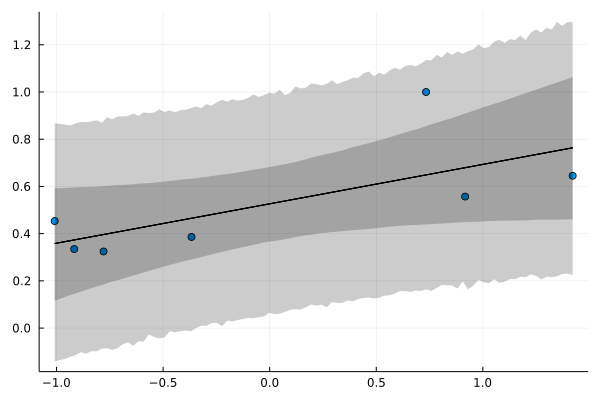

In [9]:
scatter(d.mass_std, d.brain_std)
plot!(mass_seq, [mu_mean mu_mean]; fillrange=mu_PI, c=:black, fillalpha=0.2)
plot!(mass_seq, [mu_mean mu_mean]; fillrange=sim_PI, c=:black, fillalpha=0.2)

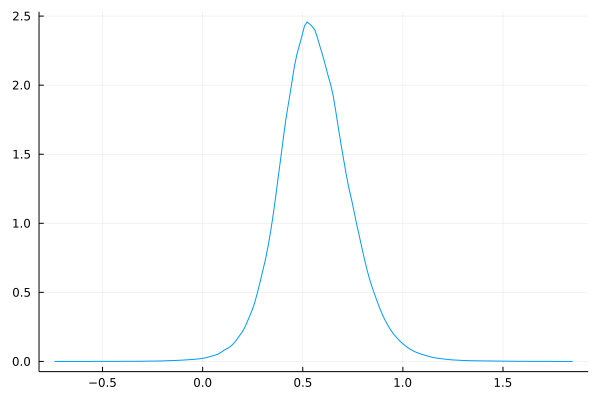

In [12]:
density(mu[:])

In [13]:
mean_and_std(mu[:])

(0.5608297508556682, 0.17999883689431884)

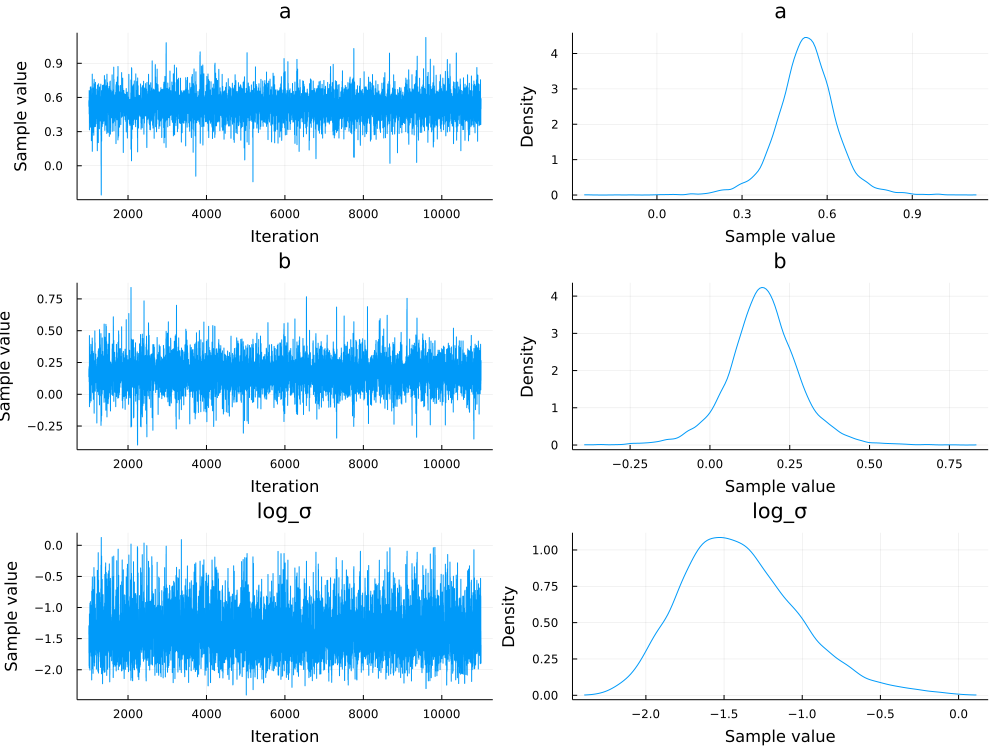

In [151]:
plot(m7_1_ch)